In [1]:
import torch, logging
import torch.nn as nn
## disable warnings

logging.disable(logging.WARNING)
## Imaging  library

from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode

In [33]:
## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("clip-vit-large-patch14").to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to("cuda")

# CLIPImage Processor
processor = CLIPProcessor.from_pretrained("clip-vit-large-patch14")
model = CLIPModel.from_pretrained("clip-vit-large-patch14")

# Initialize device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

Using cuda


In [32]:
class CIRPipeline(torch.nn.Module):
    def __init__(self, tokenizer, text_encoder, vae, scheduler, unet, processor, image_encoder, device):
        super(CIRPipeline, self).__init__()
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder.to(device)
        self.vae = vae.to(device)
        self.scheduler = scheduler
        self.unet = unet.to(device)
        self.processor = processor
        self.image_encoder = image_encoder.to(device)
        
        # Freeze all other models
        for param in self.text_encoder.parameters():
            param.requires_grad = False
            
        for param in self.vae.parameters():
            param.requires_grad = False
            
        for param in self.unet.parameters():
            param.requires_grad = False

        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_layer = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768)
        ).to(device)

        self.image_layer = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768)
        ).to(device)

        self.combined_layer = nn.Sequential(
            nn.Linear(78, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 77)
        ).to(device)        
            
    def load_image(self, p):
        '''
        Function to load images from a defined path
        '''
        return Image.open(p).convert('RGB').resize((512,512))

    def pil_to_latents(self, image):
        '''
        Function to convert image to latents
        '''
        init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
        init_image = init_image.to(device="cuda")
        init_latent_dist = self.vae.encode(init_image).latent_dist.sample() * 0.18215
        return init_latent_dist

    def latents_to_pil(self, latents):
        '''
        Function to convert latents to images
        '''
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images

    def image_enc(self, images):
        input = self.processor(images = images, return_tensors = "pt").to(device)
        return self.image_encoder.get_image_features(**input)

    def text_enc(self, prompts, maxlen=None):
        '''
        A function to take a texual prompt and convert it into embeddings
        '''
        if maxlen is None: maxlen = self.tokenizer.model_max_length
        inp = self.tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
        return self.text_encoder(inp.input_ids.to("cuda"))[0]
    
    def forward(self, images, prompts, g=7.5, seed=100, steps=70, dim=512, save_int=False):
        """
        Diffusion process to convert prompt to image
        """

        # Defining batch size
        bs = len(prompts)

        # Converting textual prompts to embedding
        text = self.combine_inputs(images, prompts)
        print("Combined Embeddings shape", text.size())
        # Adding an unconditional prompt , helps in the generation process
        uncond =  self.text_enc([""] * bs, text.shape[1])
        emb = torch.cat([uncond, text])
        print(emb.shape)

        # Setting the seed
        if seed: torch.manual_seed(seed)

        # Initiating random noise
        latents = torch.randn((bs, self.unet.config.in_channels, dim//8, dim//8))
        print(latents.size())

        # Setting number of steps in scheduler
        self.scheduler.set_timesteps(steps)

        # Adding noise to the latents
        latents = latents.to("cuda") * scheduler.init_noise_sigma

        # Iterating through defined steps
        for i,ts in enumerate(tqdm(self.scheduler.timesteps)):
            # We need to scale the i/p latents to match the variance
            inp = self.scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            # print(inp.size(), emb.size())

            # Predicting noise residual using U-Net
            with torch.no_grad(): u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            # Performing Guidance
            pred = u + g*(t-u)

            # Conditioning  the latents
            latents = self.scheduler.step(pred, ts, latents).prev_sample

        # Returning the latent representation to output an image of 3x512x512
        return self.latents_to_pil(latents)

    def combine_inputs(self, images, prompts):
        # Get batch size
        bs = len(prompts)

        # Get the text encoding
        text_encoding = self.text_enc(prompts)

        # Get image encoding
        image_encoding = self.image_enc(images)
            
        text_encoding = self.text_layer(text_encoding.view(-1, 768)).reshape(bs, -1, 768)
        image_encoding = self.image_layer(image_encoding.view(-1, 768)).reshape(bs, -1, 768)

        combined_embedding = torch.cat([text_encoding, image_encoding], axis = 1)

        combined_embedding = self.combined_layer(combined_embedding.view(-1, 78)).reshape(bs, 77, 768)
        return combined_embedding

In [34]:
pipeline = CIRPipeline(tokenizer, text_encoder, vae, scheduler, unet, processor, model, device)

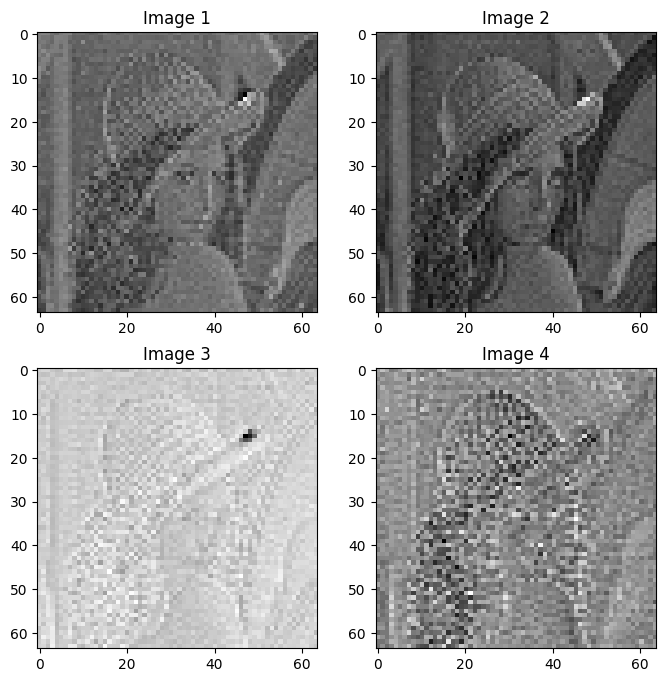

In [35]:
image = pipeline.load_image('images/lena.png')
latents = pipeline.pil_to_latents(image)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the images in the 1x4x64x64 matrix in four different subplots
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(latents.cpu().detach()[0, i], cmap='gray')
    axs[row, col].set_title(f'Image {i + 1}')

In [36]:
combined_embedding = pipeline.combine_inputs(image, ["Lena it is"])

print(combined_embedding.size())

torch.Size([1, 77, 768])


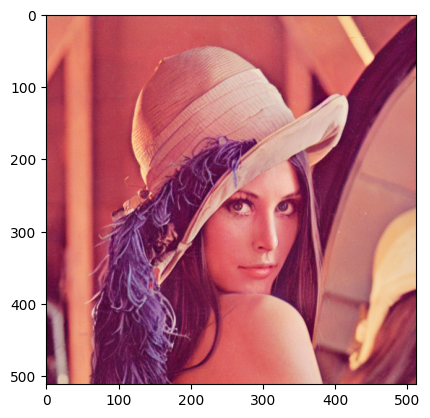

In [37]:
pil = pipeline.latents_to_pil(latents)[0]
plt.imshow(pil)

Combined Embeddings shape torch.Size([1, 77, 768])
torch.Size([2, 77, 768])
torch.Size([1, 4, 64, 64])


  0%|          | 0/70 [00:00<?, ?it/s]

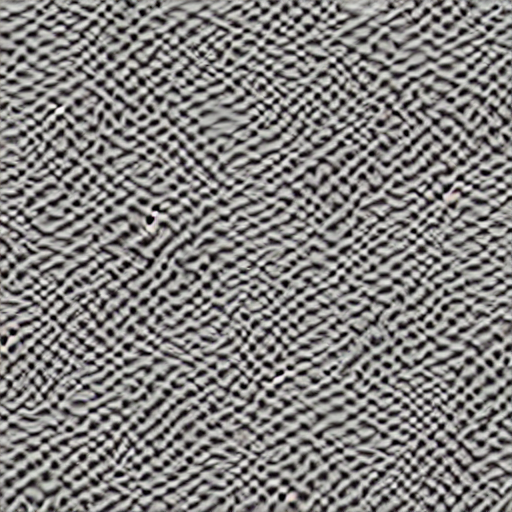

In [38]:
images = pipeline(image, ["Dressed up dogs"])
for img in images:display(img)